### Imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from joblib import load
import random
from sklearn.model_selection import train_test_split

# Reproducibility
np.random.seed(5)
random.seed(5)


### Load dataset

In [ ]:
# Last inn trenet SVM fra oppgave 1
clf = load("best_svm_model.pkl")

# Last inn datasettet
corrupted_dataset = np.load("dataset_corrupted.npz")
Xc = corrupted_dataset["X"]

dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=5
)

# modellen fra oppgave 1
clf = load("best_svm_model.pkl")

corrupted_ds = np.load("dataset_corrupted.npz")
Xc = corrupted_ds["X"]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
Xc_scaled = scaler.transform(Xc)

In [25]:
# Modellusikkerhet
probs = clf.predict_proba(Xc_scaled)
conf = probs.max(axis=1)
unc = 1.0 - conf  # høyere = mer usikker

# PCA rekonstruksjon
pca = PCA(n_components=10, random_state=5).fit(Xc_scaled)
Xc_rec = pca.inverse_transform(pca.transform(Xc_scaled))
re = np.mean((Xc_scaled - Xc_rec) ** 2, axis=1)

# Normaliser 
unc_n = (unc - unc.min()) / (unc.max() - unc.min() + 1e-8)
re_n = (re - re.min()) / (re.max() - re.min() + 1e-8)


In [26]:
features = np.vstack([unc_n, re_n]).T  # 2D-feature space

kmeans = KMeans(n_clusters=2, random_state=5)
cluster_labels = kmeans.fit_predict(features)

# Finn hvilket cluster som virker "mest korrupt"
mean_conf = [conf[cluster_labels == i].mean() for i in range(2)]
corrupted_cluster = np.argmin(mean_conf)

suspect_idx = np.where(cluster_labels == corrupted_cluster)[0]
print(f"Flagged {len(suspect_idx)} / {len(Xc)} images as potentially corrupted.")


Flagged 88 / 405 images as potentially corrupted.


c:\Users\mariu\anaconda3\envs\INF264\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## Plot

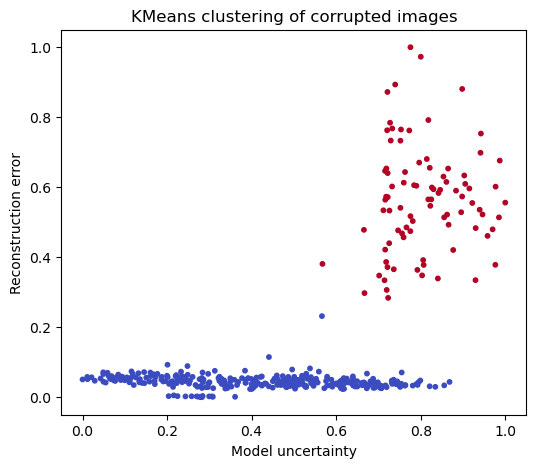

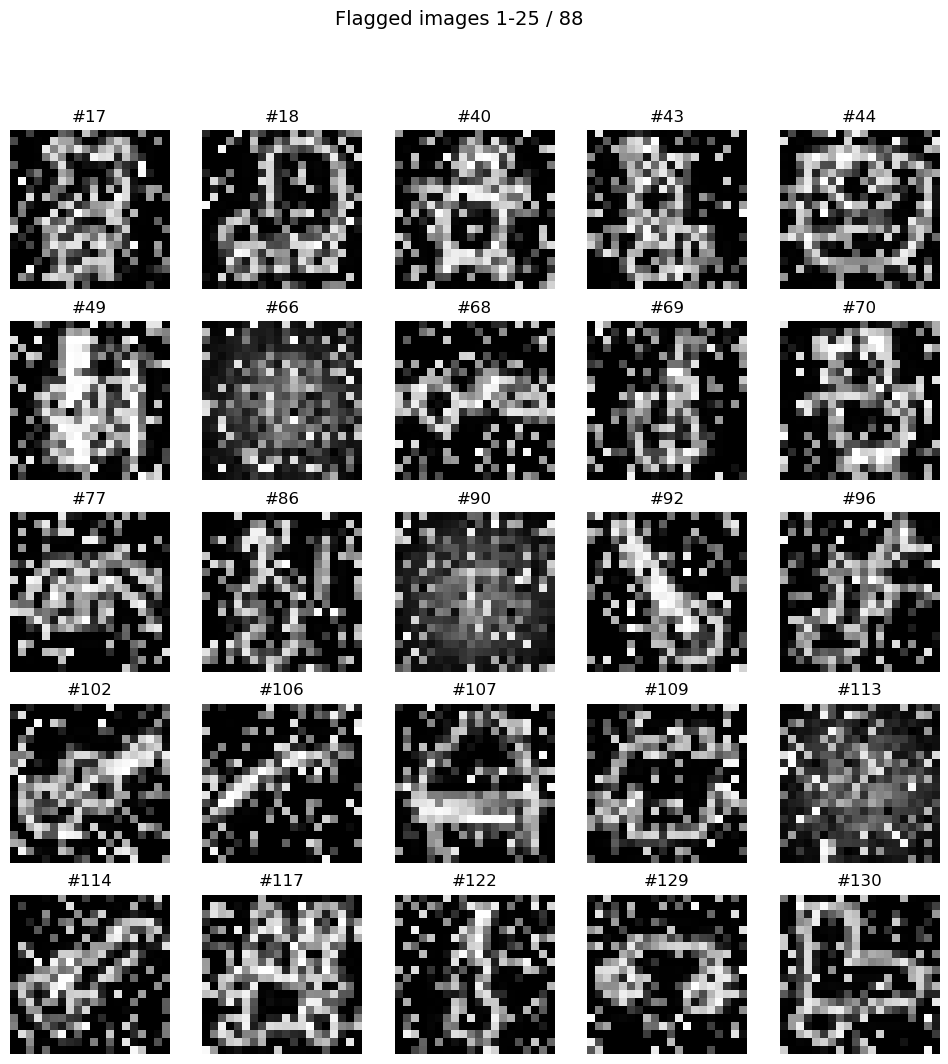

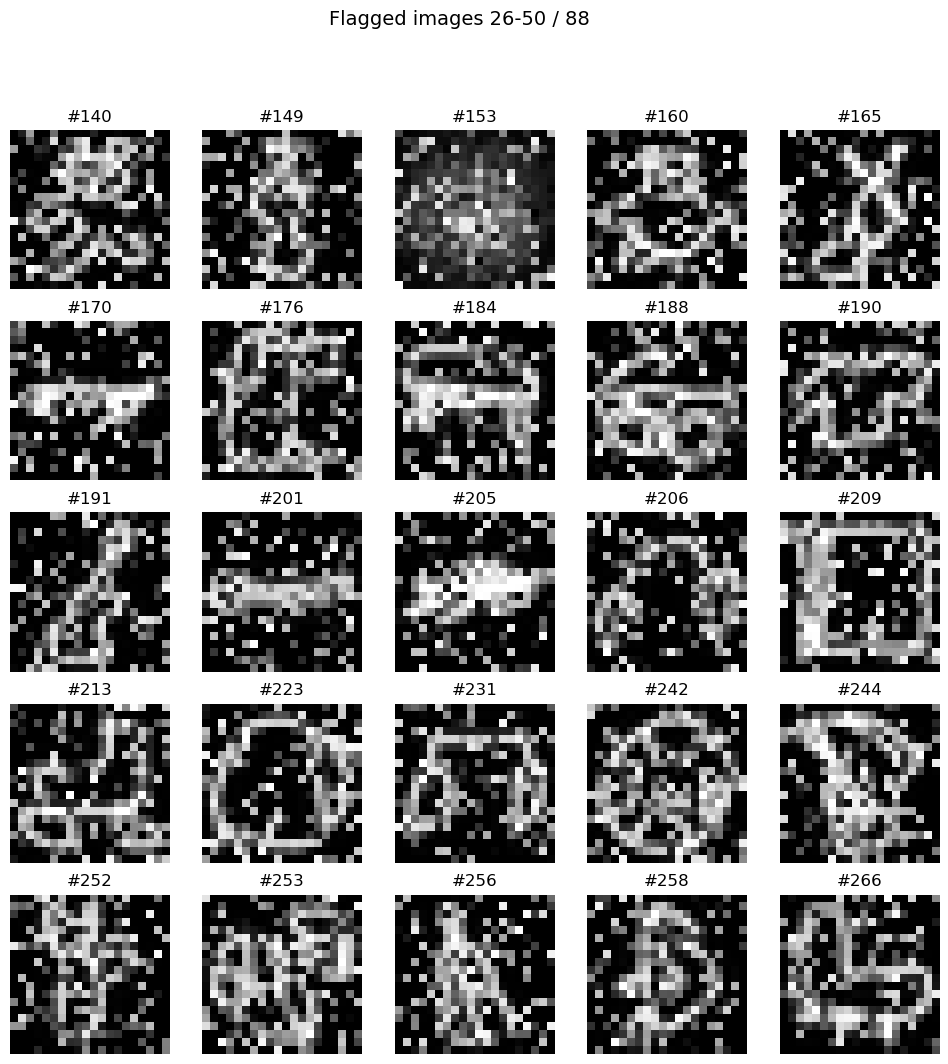

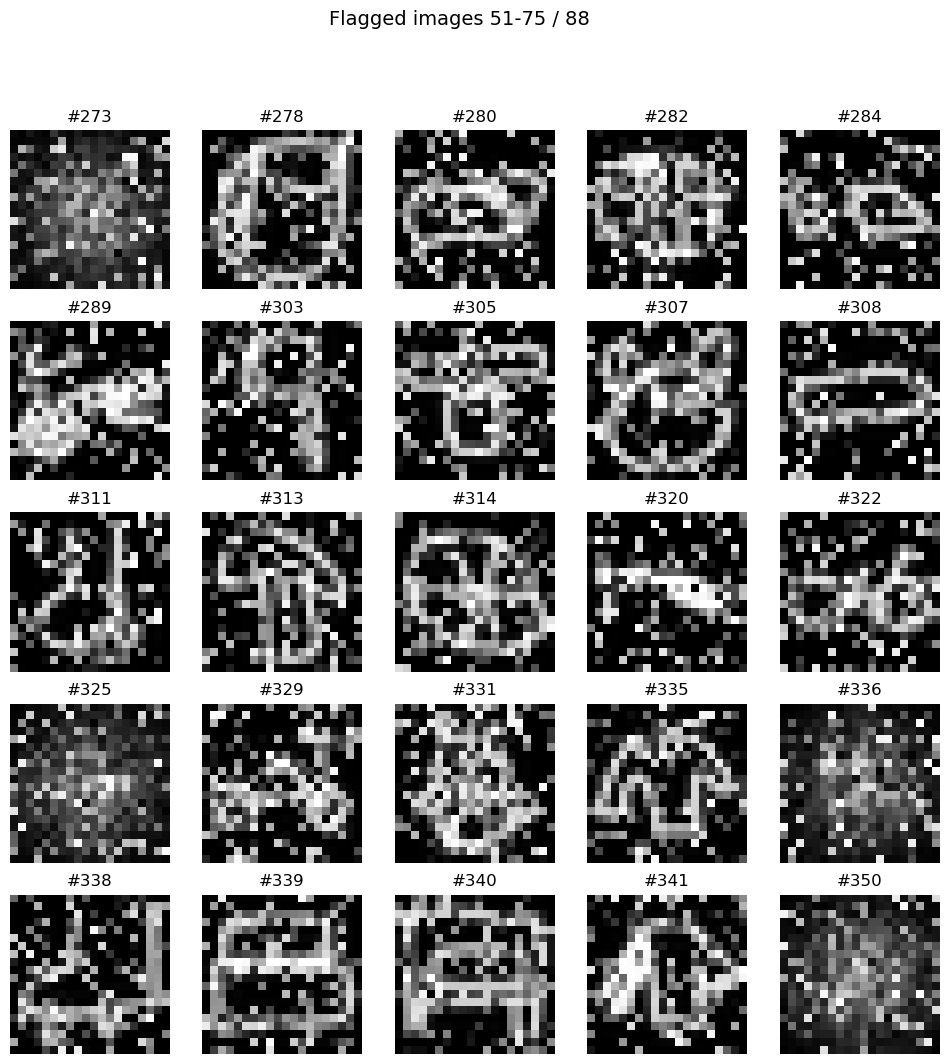

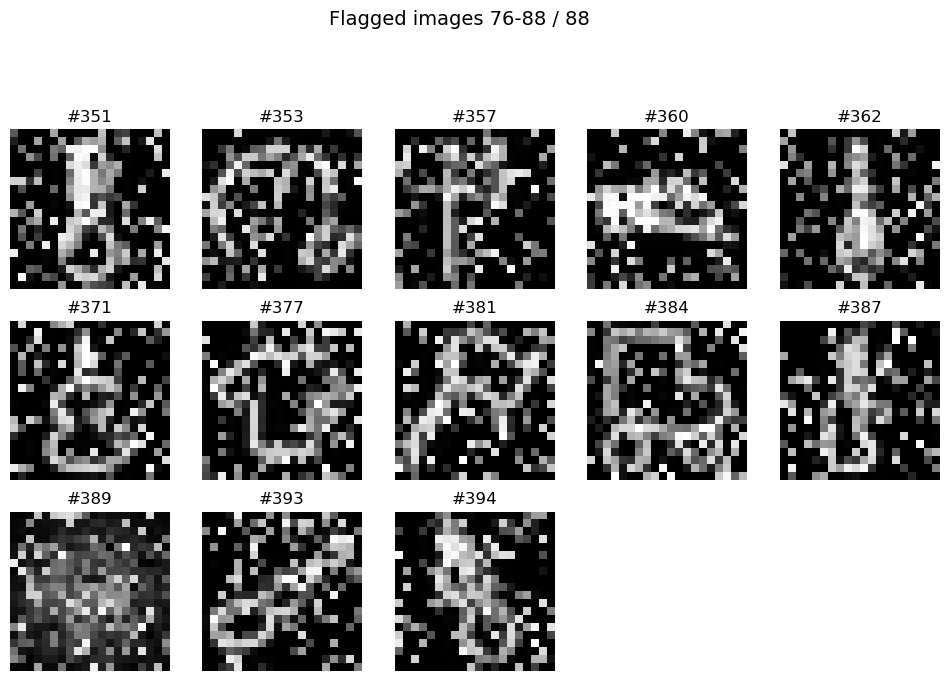

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(unc_n, re_n, c=cluster_labels, cmap="coolwarm", s=10)
plt.xlabel("Model uncertainty")
plt.ylabel("Reconstruction error")
plt.title("KMeans clustering of corrupted images")
plt.show()

# Vis 25 bilder per side
per_page = 25
n_pages = int(np.ceil(len(suspect_idx) / per_page))

for page in range(n_pages):
    start = page * per_page
    end = min(start + per_page, len(suspect_idx))
    
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(suspect_idx[start:end]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(Xc[idx].reshape(20, 20), cmap="gray")
        plt.axis('off')
        plt.title(f"#{idx}")
    plt.suptitle(f"Flagged images {start+1}-{end} / {len(suspect_idx)}", fontsize=14)
    plt.show()
